<a href="https://colab.research.google.com/github/MaheeGamage/Product-Personalization/blob/main/Product_personalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Config

In [56]:
# Google drive connection
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Basic config

In [61]:
capture_image_from_webcam = False
gdrive_products_path = "/Other/Dula MBA Experiment/Products"

Other Config. No need to change for execution

In [81]:
person_image_folder_path = '/content/PersonImage'

background_remover_input_folder_path = '/content/MODNet/demo/image_matting/colab/input'
background_remover_output_folder_path = '/content/MODNet/demo/image_matting/colab/output'

products_image_path = "/content/drive/MyDrive" + gdrive_products_path
products_image_config_file_name = "image_generation_config.json"

## Setup

In [45]:
# Folder Structure Setup
import os.path
from os import path
import shutil

# clean and rebuild the person image folder
if os.path.exists(person_image_folder_path):
  shutil.rmtree(person_image_folder_path)
os.makedirs(person_image_folder_path)

In [46]:
# Background remover setup

import os
import shutil
from google.colab import files

# clone the repository
%cd /content
if not os.path.exists('MODNet'):
  !git clone https://github.com/MaheeGamage/MODNet
%cd MODNet/

# dowload the pre-trained ckpt for image matting
pretrained_ckpt = 'pretrained/modnet_photographic_portrait_matting.ckpt'
if not os.path.exists(pretrained_ckpt):
  !gdown --id 1uXRxXvizrwSj9-FlxqEuwDIhkb9E28y5 \
          -O pretrained/modnet_photographic_portrait_matting.ckpt

# clean and rebuild the image folders
if os.path.exists(background_remover_input_folder_path):
  shutil.rmtree(background_remover_input_folder_path)
os.makedirs(background_remover_input_folder_path)

if os.path.exists(background_remover_output_folder_path):
  shutil.rmtree(background_remover_output_folder_path)
os.makedirs(background_remover_output_folder_path)

/content
/content/MODNet


## Capture Webcam image

In [47]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Fetch webcam photo or prompt for a image
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [48]:
from IPython.display import Image
from google.colab import files
import os

if capture_image_from_webcam :
  try:
    filename = take_photo(person_image_folder_path + "/photo.jpg")
    print('Saved to {}'.format(filename))
    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
else :
  os.chdir(person_image_folder_path)
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving Mahee.jpg to Mahee.jpg
User uploaded file "Mahee.jpg" with length 380736 bytes


In [49]:
# copy images from person image folder to background remover input folder
import shutil

shutil.copytree(person_image_folder_path, background_remover_input_folder_path, dirs_exist_ok=True) 

'/content/MODNet/demo/image_matting/colab/input'

## Remove background of person's image

In [50]:
%cd /content/MODNet

!python -m demo.image_matting.colab.inference \
        --input-path demo/image_matting/colab/input \
        --output-path demo/image_matting/colab/output \
        --ckpt-path ./pretrained/modnet_photographic_portrait_matting.ckpt

/content/MODNet
Process image: Mahee.jpg


Displaying Background Removed Image

In [51]:
import numpy as np
from PIL import Image

def combined_display(image, matte):
  # calculate display resolution
  w, h = image.width, image.height
  rw, rh = 800, int(h * 800 / (3 * w))
  
  # obtain predicted foreground
  image = np.asarray(image)
  if len(image.shape) == 2:
    image = image[:, :, None]
  if image.shape[2] == 1:
    image = np.repeat(image, 3, axis=2)
  elif image.shape[2] == 4:
    image = image[:, :, 0:3]
  matte = np.repeat(np.asarray(matte)[:, :, None], 3, axis=2) / 255
  foreground = image * matte + np.full(image.shape, 255) * (1 - matte)
  
  # combine image, foreground, and alpha into one line
  combined = np.concatenate((image, foreground, matte * 255), axis=1)
  combined = Image.fromarray(np.uint8(combined)).resize((rw, rh))
  return combined, image, foreground, matte * 255

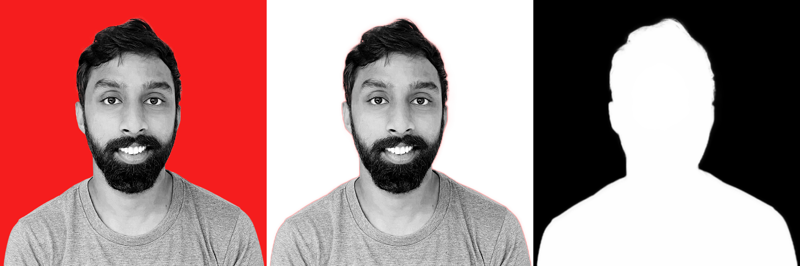

Mahee.jpg 



In [52]:
# visualize all images
image_names = os.listdir(background_remover_input_folder_path)
for image_name in image_names:
  matte_name = image_name.split('.')[0] + '.png'
  image = Image.open(os.path.join(background_remover_input_folder_path, image_name))
  matte = Image.open(os.path.join(background_remover_output_folder_path, matte_name))
  display(combined_display(image, matte)[0])
  print(image_name, '\n')

In [53]:
# Scan Google drive location for product(background) images or prompt for product images

/content/drive/MyDrive/Other/Dula MBA Experiment/Products
[{'imageName': 'General_wallclock.png', 'personImageOffset': {'x_offset': 800, 'y_offset': 1100}}]


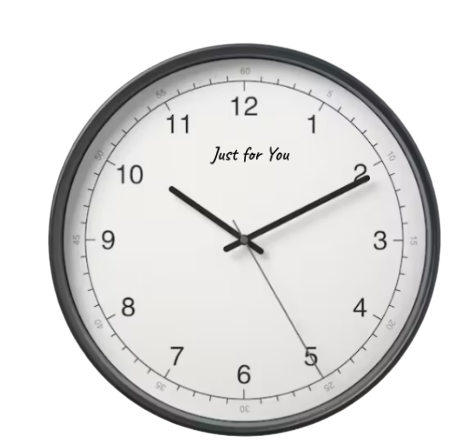

In [87]:
import json
from IPython.display import Image

%cd {products_image_path}

with open(products_image_config_file_name, "r") as fid: 
     productConfig = json.load(fid)
        
print(productConfig)

for product in productConfig:
    product_image = products_image_path + "/" + product["imageName"]
    display(Image(product_image))

In [54]:
# Config person photo location for each product image

In [55]:
# Loop through each product image and paste person image(background removed) into each product image